In [1]:
import json
import pandas as pd

# Load your dataset from the Downloads folder
with open("/Users/rajeshwarraothakkallapally/Downloads/jobmatch_dataset.json", "r") as f:
    data = json.load(f)

# Convert JSON to pandas DataFrame
df = pd.DataFrame(data)

# Display first few records
print(df.head())


                                     job_description  \
0  Looking for a software engineer skilled in Spr...   
1  Looking for a software engineer skilled in Pos...   
2  Looking for a software engineer skilled in Pyt...   
3  Looking for a software engineer skilled in NLP...   
4  Looking for a software engineer skilled in Mic...   

                                      resume_summary  match_score  \
0  The candidate has experience in Spring Boot, A...           20   
1  The candidate has experience in NLP, Python, R...           20   
2  The candidate has experience in MySQL, React, ...            0   
3  The candidate has experience in Machine Learni...           16   
4  The candidate has experience in GCP, Django, M...           40   

                                         explanation  
0  Very low match: candidate lacks key required s...  
1  Very low match: candidate lacks key required s...  
2  Very low match: candidate lacks key required s...  
3  Very low match: candidate

In [2]:
# Check total rows
print("Total examples:", len(df))

# Check available columns
print("Columns:", df.columns.tolist())

# Show example record
print(df.iloc[0])


Total examples: 1000
Columns: ['job_description', 'resume_summary', 'match_score', 'explanation']
job_description    Looking for a software engineer skilled in Spr...
resume_summary     The candidate has experience in Spring Boot, A...
match_score                                                       20
explanation        Very low match: candidate lacks key required s...
Name: 0, dtype: object


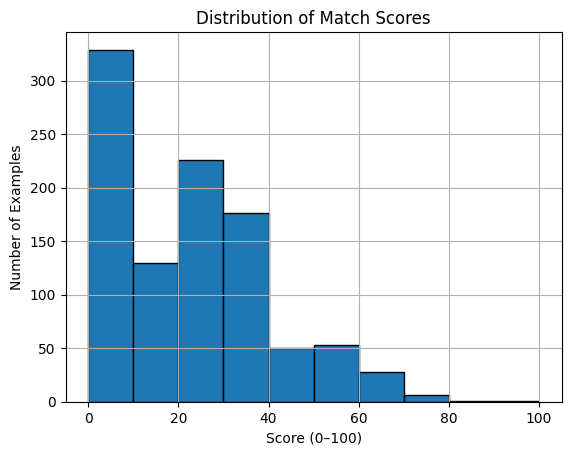

In [3]:
import matplotlib.pyplot as plt

df["match_score"].hist(bins=10, edgecolor='black')
plt.title("Distribution of Match Scores")
plt.xlabel("Score (0–100)")
plt.ylabel("Number of Examples")
plt.grid(True)
plt.show()


In [4]:
def score_to_label(score):
    if score <= 25:
        return 0
    elif score <= 60:
        return 1
    else:
        return 2

df["match_label"] = df["match_score"].apply(score_to_label)
df[["match_score", "match_label"]].head()


,match_score,match_label
0,20,0
1,20,0
2,0,0
3,16,0
4,40,1


In [5]:
import pandas as pd
import json

# Load dataset (already labeled from Phase 1)
with open("/Users/rajeshwarraothakkallapally/Downloads/jobmatch_dataset.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Labeling function
def score_to_label(score):
    if score <= 25:
        return 0
    elif score <= 60:
        return 1
    else:
        return 2

df["label"] = df["match_score"].apply(score_to_label)
df = df[["job_description", "resume_summary", "label"]]
df.head()


,job_description,resume_summary,label
0,Looking for a software engineer skilled in Spr...,"The candidate has experience in Spring Boot, A...",0
1,Looking for a software engineer skilled in Pos...,"The candidate has experience in NLP, Python, R...",0
2,Looking for a software engineer skilled in Pyt...,"The candidate has experience in MySQL, React, ...",0
3,Looking for a software engineer skilled in NLP...,The candidate has experience in Machine Learni...,0
4,Looking for a software engineer skilled in Mic...,"The candidate has experience in GCP, Django, M...",1


In [6]:
df["input_text"] = "Job: " + df["job_description"] + " Resume: " + df["resume_summary"]
df = df[["input_text", "label"]]


In [7]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["input_text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42
)


In [8]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = bert_tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = bert_tokenizer(val_texts, truncation=True, padding=True, max_length=256)


/Users/rajeshwarraothakkallapally/miniconda3/envs/langchain311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import torch

class ResumeMatchDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {
            "labels": torch.tensor(self.labels[idx])
        }

train_dataset = ResumeMatchDataset(train_encodings, train_labels)
val_dataset = ResumeMatchDataset(val_encodings, val_labels)


In [10]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

bert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

training_args = TrainingArguments(
    output_dir="./bert-resume-classifier",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
trainer.train()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 0/300 [00:00<?, ?it/s]/Users/rajeshwarraothakkallapally/miniconda3/envs/langchain311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                                                 
 33%|███▎      | 100/300 [00:29<00:53,  3.73it/s]

{'eval_loss': 0.4406709372997284, 'eval_runtime': 1.3111, 'eval_samples_per_second': 152.543, 'eval_steps_per_second': 19.068, 'epoch': 1.0}


/Users/rajeshwarraothakkallapally/miniconda3/envs/langchain311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                                                 
 67%|██████▋   | 200/300 [00:58<00:26,  3.77it/s]

{'eval_loss': 0.333760142326355, 'eval_runtime': 1.2445, 'eval_samples_per_second': 160.712, 'eval_steps_per_second': 20.089, 'epoch': 2.0}


/Users/rajeshwarraothakkallapally/miniconda3/envs/langchain311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                                                 
100%|██████████| 300/300 [01:27<00:00,  3.76it/s]

{'eval_loss': 0.2790907919406891, 'eval_runtime': 1.283, 'eval_samples_per_second': 155.887, 'eval_steps_per_second': 19.486, 'epoch': 3.0}


100%|██████████| 300/300 [01:28<00:00,  3.38it/s]

{'train_runtime': 88.8874, 'train_samples_per_second': 27.0, 'train_steps_per_second': 3.375, 'train_loss': 0.3980644989013672, 'epoch': 3.0}


TrainOutput(global_step=300, training_loss=0.3980644989013672, metrics={'train_runtime': 88.8874, 'train_samples_per_second': 27.0, 'train_steps_per_second': 3.375, 'total_flos': 81400713609600.0, 'train_loss': 0.3980644989013672, 'epoch': 3.0})

In [12]:
trainer.evaluate()


/Users/rajeshwarraothakkallapally/miniconda3/envs/langchain311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 25/25 [00:01<00:00, 20.60it/s]


{'eval_loss': 0.2790907919406891,
 'eval_runtime': 1.2317,
 'eval_samples_per_second': 162.381,
 'eval_steps_per_second': 20.298,
 'epoch': 3.0}

In [13]:
def predict_match_label(job_description, resume_summary, model, tokenizer):
    model.eval()
    model.to("cpu")  # 💥 Force model to CPU

    input_text = f"Job: {job_description} Resume: {resume_summary}"
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    inputs = {k: v.to("cpu") for k, v in inputs.items()}  # 💥 Also move inputs to CPU

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_class = torch.argmax(outputs.logits, dim=1).item()

    label_map = {0: "Low Match", 1: "Medium Match", 2: "High Match"}
    return label_map[predicted_class]


In [14]:
job = "Looking for a backend developer with Java, Spring Boot, and MySQL experience."
resume = "Experienced in Java and Spring Boot, with strong SQL background."

result = predict_match_label(job, resume, bert_model, bert_tokenizer)
print("Prediction:", result)


Prediction: Medium Match


In [15]:
import json

# Load dataset from your path
with open("/Users/rajeshwarraothakkallapally/Downloads/jobmatch_dataset.json") as f:
    data = json.load(f)

# Prepare lists
inputs, targets = [], []

for item in data:
    job = item["job_description"]
    resume = item["resume_summary"]
    explanation = item["explanation"]

    prompt = f"Explain why this resume fits the job:\nJob: {job}\nResume: {resume}"
    inputs.append(prompt)
    targets.append(explanation)


In [16]:
from transformers import AutoTokenizer

model_name = "google/flan-t5-small"
flan_tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize inputs and outputs
input_encodings = flan_tokenizer(inputs, padding=True, truncation=True, max_length=512, return_tensors="pt")
target_encodings = flan_tokenizer(targets, padding=True, truncation=True, max_length=128, return_tensors="pt")


In [17]:
import torch

class T5ExplanationDataset(torch.utils.data.Dataset):
    def __init__(self, input_encodings, target_encodings, indices):
        self.input_ids = input_encodings["input_ids"][indices]
        self.attention_mask = input_encodings["attention_mask"][indices]
        self.labels = target_encodings["input_ids"][indices]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }


In [18]:
from sklearn.model_selection import train_test_split

# Get the total dataset size
n_samples = len(inputs)
all_indices = list(range(n_samples))

# Split indices
train_idx, val_idx = train_test_split(all_indices, test_size=0.1, random_state=42)

# Build datasets
train_dataset = T5ExplanationDataset(input_encodings, target_encodings, train_idx)
val_dataset = T5ExplanationDataset(input_encodings, target_encodings, val_idx)


In [19]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments

# Load model
flan_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")

# Training config
training_args = Seq2SeqTrainingArguments(
    output_dir="./flan-t5-explainer",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=10,
    fp16=False  # Keep False if not using GPU with float16 support
)


/Users/rajeshwarraothakkallapally/miniconda3/envs/langchain311/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=flan_tokenizer, model=flan_model)

trainer = Seq2SeqTrainer(
    model=flan_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=flan_tokenizer,
    data_collator=data_collator
)


In [21]:
trainer.train()


  0%|          | 0/675 [00:00<?, ?it/s]/Users/rajeshwarraothakkallapally/miniconda3/envs/langchain311/lib/python3.11/site-packages/transformers/data/data_collator.py:646: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
  2%|▏         | 11/675 [00:02<01:49,  6.04it/s]

{'loss': 6.5628, 'grad_norm': 11.422966957092285, 'learning_rate': 0.0002955555555555555, 'epoch': 0.04}


  3%|▎         | 21/675 [00:03<01:45,  6.21it/s]

{'loss': 1.8927, 'grad_norm': 21.846508026123047, 'learning_rate': 0.0002911111111111111, 'epoch': 0.09}


  5%|▍         | 31/675 [00:05<01:42,  6.27it/s]

{'loss': 0.7113, 'grad_norm': 3.4581823348999023, 'learning_rate': 0.0002866666666666667, 'epoch': 0.13}


  6%|▌         | 41/675 [00:06<01:41,  6.26it/s]

{'loss': 0.5935, 'grad_norm': 4.333836555480957, 'learning_rate': 0.00028222222222222223, 'epoch': 0.18}


  8%|▊         | 51/675 [00:08<01:39,  6.27it/s]

{'loss': 0.3826, 'grad_norm': 4.156271457672119, 'learning_rate': 0.0002777777777777778, 'epoch': 0.22}


  9%|▉         | 61/675 [00:10<01:38,  6.27it/s]

{'loss': 0.2374, 'grad_norm': 1.2317200899124146, 'learning_rate': 0.00027333333333333333, 'epoch': 0.27}


 11%|█         | 71/675 [00:11<01:36,  6.27it/s]

{'loss': 0.2048, 'grad_norm': 1.4795747995376587, 'learning_rate': 0.0002688888888888889, 'epoch': 0.31}


 12%|█▏        | 81/675 [00:13<01:34,  6.28it/s]

{'loss': 0.1311, 'grad_norm': 0.9906775951385498, 'learning_rate': 0.00026444444444444443, 'epoch': 0.36}


 13%|█▎        | 91/675 [00:14<01:32,  6.28it/s]

{'loss': 0.0976, 'grad_norm': 1.8553338050842285, 'learning_rate': 0.00026, 'epoch': 0.4}


 15%|█▍        | 101/675 [00:16<01:31,  6.28it/s]

{'loss': 0.0812, 'grad_norm': 0.6326224207878113, 'learning_rate': 0.00025555555555555553, 'epoch': 0.44}


 16%|█▋        | 111/675 [00:18<01:29,  6.28it/s]

{'loss': 0.0947, 'grad_norm': 0.3302457630634308, 'learning_rate': 0.0002511111111111111, 'epoch': 0.49}


 18%|█▊        | 120/675 [00:19<01:32,  5.99it/s]

{'loss': 0.0905, 'grad_norm': 1.2534388303756714, 'learning_rate': 0.0002466666666666666, 'epoch': 0.53}


 19%|█▉        | 131/675 [00:21<01:36,  5.64it/s]

{'loss': 0.0656, 'grad_norm': 0.46083518862724304, 'learning_rate': 0.0002422222222222222, 'epoch': 0.58}


 21%|██        | 141/675 [00:23<01:35,  5.60it/s]

{'loss': 0.157, 'grad_norm': 2.2688841819763184, 'learning_rate': 0.00023777777777777775, 'epoch': 0.62}


 22%|██▏       | 151/675 [00:25<01:28,  5.89it/s]

{'loss': 0.0822, 'grad_norm': 0.9365343451499939, 'learning_rate': 0.0002333333333333333, 'epoch': 0.67}


 24%|██▍       | 161/675 [00:26<01:24,  6.07it/s]

{'loss': 0.0749, 'grad_norm': 0.44631269574165344, 'learning_rate': 0.00022888888888888885, 'epoch': 0.71}


 25%|██▌       | 171/675 [00:28<01:29,  5.66it/s]

{'loss': 0.0656, 'grad_norm': 1.2343885898590088, 'learning_rate': 0.0002244444444444444, 'epoch': 0.76}


 27%|██▋       | 181/675 [00:30<01:19,  6.19it/s]

{'loss': 0.0635, 'grad_norm': 0.7096039652824402, 'learning_rate': 0.00021999999999999995, 'epoch': 0.8}


 28%|██▊       | 191/675 [00:31<01:18,  6.16it/s]

{'loss': 0.0782, 'grad_norm': 0.9466565847396851, 'learning_rate': 0.00021555555555555556, 'epoch': 0.84}


 30%|██▉       | 201/675 [00:33<01:17,  6.15it/s]

{'loss': 0.0501, 'grad_norm': 0.4980361759662628, 'learning_rate': 0.0002111111111111111, 'epoch': 0.89}


 31%|███▏      | 211/675 [00:34<01:14,  6.20it/s]

{'loss': 0.0877, 'grad_norm': 1.9141993522644043, 'learning_rate': 0.00020666666666666666, 'epoch': 0.93}


 33%|███▎      | 221/675 [00:36<01:13,  6.18it/s]

{'loss': 0.0458, 'grad_norm': 0.5332560539245605, 'learning_rate': 0.0002022222222222222, 'epoch': 0.98}


                                                 
 33%|███▎      | 225/675 [00:37<01:12,  6.19it/s]

{'eval_loss': 0.058481182903051376, 'eval_runtime': 0.6575, 'eval_samples_per_second': 152.096, 'eval_steps_per_second': 38.024, 'epoch': 1.0}


/Users/rajeshwarraothakkallapally/miniconda3/envs/langchain311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 34%|███▍      | 231/675 [00:40<01:54,  3.86it/s]

{'loss': 0.0792, 'grad_norm': 1.0794386863708496, 'learning_rate': 0.00019777777777777776, 'epoch': 1.02}


 36%|███▌      | 241/675 [00:41<01:10,  6.13it/s]

{'loss': 0.0369, 'grad_norm': 1.2000808715820312, 'learning_rate': 0.00019333333333333333, 'epoch': 1.07}


 37%|███▋      | 251/675 [00:43<01:08,  6.18it/s]

{'loss': 0.0367, 'grad_norm': 1.5773566961288452, 'learning_rate': 0.00018888888888888888, 'epoch': 1.11}


 39%|███▊      | 261/675 [00:44<01:07,  6.17it/s]

{'loss': 0.0918, 'grad_norm': 1.1726943254470825, 'learning_rate': 0.00018444444444444443, 'epoch': 1.16}


 40%|████      | 271/675 [00:46<01:05,  6.21it/s]

{'loss': 0.0534, 'grad_norm': 0.9225012063980103, 'learning_rate': 0.00017999999999999998, 'epoch': 1.2}


 42%|████▏     | 281/675 [00:48<01:03,  6.20it/s]

{'loss': 0.0536, 'grad_norm': 0.9488732218742371, 'learning_rate': 0.00017555555555555553, 'epoch': 1.24}


 43%|████▎     | 291/675 [00:49<01:01,  6.21it/s]

{'loss': 0.0677, 'grad_norm': 5.277588844299316, 'learning_rate': 0.0001711111111111111, 'epoch': 1.29}


 44%|████▍     | 300/675 [00:51<01:08,  5.47it/s]

{'loss': 0.0496, 'grad_norm': 0.4188045561313629, 'learning_rate': 0.00016666666666666666, 'epoch': 1.33}


 46%|████▌     | 311/675 [00:53<01:00,  6.01it/s]

{'loss': 0.0392, 'grad_norm': 0.16795124113559723, 'learning_rate': 0.0001622222222222222, 'epoch': 1.38}


 48%|████▊     | 321/675 [00:54<00:58,  6.07it/s]

{'loss': 0.0339, 'grad_norm': 0.467022567987442, 'learning_rate': 0.00015777777777777776, 'epoch': 1.42}


 49%|████▉     | 331/675 [00:56<00:56,  6.11it/s]

{'loss': 0.0445, 'grad_norm': 0.4763122797012329, 'learning_rate': 0.0001533333333333333, 'epoch': 1.47}


 51%|█████     | 341/675 [00:58<00:53,  6.19it/s]

{'loss': 0.0334, 'grad_norm': 0.7554382085800171, 'learning_rate': 0.00014888888888888886, 'epoch': 1.51}


 52%|█████▏    | 351/675 [00:59<00:52,  6.16it/s]

{'loss': 0.0352, 'grad_norm': 1.041372537612915, 'learning_rate': 0.0001444444444444444, 'epoch': 1.56}


 53%|█████▎    | 361/675 [01:01<00:50,  6.21it/s]

{'loss': 0.0309, 'grad_norm': 0.8332885503768921, 'learning_rate': 0.00014, 'epoch': 1.6}


 55%|█████▍    | 371/675 [01:03<00:49,  6.18it/s]

{'loss': 0.0499, 'grad_norm': 0.47756922245025635, 'learning_rate': 0.00013555555555555554, 'epoch': 1.64}


 56%|█████▋    | 381/675 [01:04<00:47,  6.16it/s]

{'loss': 0.0322, 'grad_norm': 0.5824627876281738, 'learning_rate': 0.00013111111111111111, 'epoch': 1.69}


 58%|█████▊    | 391/675 [01:06<00:45,  6.20it/s]

{'loss': 0.0466, 'grad_norm': 0.6032866835594177, 'learning_rate': 0.00012666666666666666, 'epoch': 1.73}


 59%|█████▉    | 401/675 [01:07<00:44,  6.17it/s]

{'loss': 0.0274, 'grad_norm': 0.672117292881012, 'learning_rate': 0.00012222222222222221, 'epoch': 1.78}


 61%|██████    | 411/675 [01:09<00:42,  6.19it/s]

{'loss': 0.0295, 'grad_norm': 0.6259301900863647, 'learning_rate': 0.00011777777777777776, 'epoch': 1.82}


 62%|██████▏   | 421/675 [01:11<00:41,  6.18it/s]

{'loss': 0.029, 'grad_norm': 1.0533835887908936, 'learning_rate': 0.00011333333333333331, 'epoch': 1.87}


 64%|██████▍   | 431/675 [01:12<00:39,  6.16it/s]

{'loss': 0.0385, 'grad_norm': 1.235236406326294, 'learning_rate': 0.00010888888888888889, 'epoch': 1.91}


 65%|██████▌   | 441/675 [01:14<00:38,  6.15it/s]

{'loss': 0.0439, 'grad_norm': 0.26045921444892883, 'learning_rate': 0.00010444444444444444, 'epoch': 1.96}


 67%|██████▋   | 450/675 [01:15<00:36,  6.20it/s]

{'loss': 0.0354, 'grad_norm': 2.2506461143493652, 'learning_rate': 9.999999999999999e-05, 'epoch': 2.0}


                                                 
 67%|██████▋   | 450/675 [01:16<00:36,  6.20it/s]

{'eval_loss': 0.03388705849647522, 'eval_runtime': 0.6726, 'eval_samples_per_second': 148.672, 'eval_steps_per_second': 37.168, 'epoch': 2.0}


/Users/rajeshwarraothakkallapally/miniconda3/envs/langchain311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 68%|██████▊   | 461/675 [01:19<00:37,  5.71it/s]

{'loss': 0.0137, 'grad_norm': 0.19126233458518982, 'learning_rate': 9.555555555555555e-05, 'epoch': 2.04}


 70%|██████▉   | 471/675 [01:20<00:33,  6.09it/s]

{'loss': 0.0368, 'grad_norm': 1.870413064956665, 'learning_rate': 9.11111111111111e-05, 'epoch': 2.09}


 71%|███████▏  | 481/675 [01:22<00:31,  6.08it/s]

{'loss': 0.0383, 'grad_norm': 1.4053372144699097, 'learning_rate': 8.666666666666665e-05, 'epoch': 2.13}


 73%|███████▎  | 491/675 [01:24<00:29,  6.17it/s]

{'loss': 0.0233, 'grad_norm': 1.3353630304336548, 'learning_rate': 8.222222222222222e-05, 'epoch': 2.18}


 74%|███████▍  | 501/675 [01:25<00:28,  6.16it/s]

{'loss': 0.0229, 'grad_norm': 0.06011587753891945, 'learning_rate': 7.777777777777777e-05, 'epoch': 2.22}


 76%|███████▌  | 511/675 [01:27<00:26,  6.15it/s]

{'loss': 0.0278, 'grad_norm': 1.3773515224456787, 'learning_rate': 7.333333333333332e-05, 'epoch': 2.27}


 77%|███████▋  | 521/675 [01:29<00:25,  5.98it/s]

{'loss': 0.0131, 'grad_norm': 0.10492651909589767, 'learning_rate': 6.888888888888888e-05, 'epoch': 2.31}


 79%|███████▊  | 531/675 [01:30<00:23,  6.15it/s]

{'loss': 0.022, 'grad_norm': 0.9954889416694641, 'learning_rate': 6.444444444444444e-05, 'epoch': 2.36}


 80%|████████  | 541/675 [01:32<00:21,  6.18it/s]

{'loss': 0.0345, 'grad_norm': 0.5367124080657959, 'learning_rate': 5.9999999999999995e-05, 'epoch': 2.4}


 82%|████████▏ | 551/675 [01:34<00:20,  6.05it/s]

{'loss': 0.0202, 'grad_norm': 0.25580528378486633, 'learning_rate': 5.5555555555555545e-05, 'epoch': 2.44}


 83%|████████▎ | 561/675 [01:35<00:19,  5.72it/s]

{'loss': 0.0157, 'grad_norm': 0.2491489052772522, 'learning_rate': 5.111111111111111e-05, 'epoch': 2.49}


 85%|████████▍ | 571/675 [01:37<00:19,  5.34it/s]

{'loss': 0.0529, 'grad_norm': 0.43343350291252136, 'learning_rate': 4.6666666666666665e-05, 'epoch': 2.53}


 86%|████████▌ | 581/675 [01:39<00:16,  5.66it/s]

{'loss': 0.0313, 'grad_norm': 1.01418936252594, 'learning_rate': 4.222222222222222e-05, 'epoch': 2.58}


 88%|████████▊ | 591/675 [01:41<00:14,  5.74it/s]

{'loss': 0.0188, 'grad_norm': 1.4280107021331787, 'learning_rate': 3.777777777777777e-05, 'epoch': 2.62}


 89%|████████▉ | 601/675 [01:42<00:12,  5.84it/s]

{'loss': 0.0294, 'grad_norm': 2.3937854766845703, 'learning_rate': 3.333333333333333e-05, 'epoch': 2.67}


 91%|█████████ | 611/675 [01:44<00:10,  5.86it/s]

{'loss': 0.0322, 'grad_norm': 0.6150193810462952, 'learning_rate': 2.8888888888888885e-05, 'epoch': 2.71}


 92%|█████████▏| 621/675 [01:46<00:09,  5.75it/s]

{'loss': 0.0105, 'grad_norm': 0.17364594340324402, 'learning_rate': 2.4444444444444445e-05, 'epoch': 2.76}


 93%|█████████▎| 631/675 [01:48<00:07,  5.67it/s]

{'loss': 0.0291, 'grad_norm': 1.3081144094467163, 'learning_rate': 1.9999999999999998e-05, 'epoch': 2.8}


 95%|█████████▍| 641/675 [01:49<00:05,  5.72it/s]

{'loss': 0.0183, 'grad_norm': 2.064584970474243, 'learning_rate': 1.5555555555555555e-05, 'epoch': 2.84}


 96%|█████████▋| 651/675 [01:51<00:04,  5.09it/s]

{'loss': 0.0306, 'grad_norm': 1.5690209865570068, 'learning_rate': 1.111111111111111e-05, 'epoch': 2.89}


 98%|█████████▊| 661/675 [01:53<00:02,  5.31it/s]

{'loss': 0.0098, 'grad_norm': 0.8029831647872925, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.93}


 99%|█████████▉| 671/675 [01:55<00:00,  5.43it/s]

{'loss': 0.0217, 'grad_norm': 1.567793846130371, 'learning_rate': 2.222222222222222e-06, 'epoch': 2.98}


                                                 
100%|██████████| 675/675 [01:57<00:00,  5.28it/s]

{'eval_loss': 0.04708433151245117, 'eval_runtime': 0.9324, 'eval_samples_per_second': 107.252, 'eval_steps_per_second': 26.813, 'epoch': 3.0}


100%|██████████| 675/675 [01:58<00:00,  5.70it/s]

{'train_runtime': 118.3762, 'train_samples_per_second': 22.809, 'train_steps_per_second': 5.702, 'train_loss': 0.1990478127642914, 'epoch': 3.0}


TrainOutput(global_step=675, training_loss=0.1990478127642914, metrics={'train_runtime': 118.3762, 'train_samples_per_second': 22.809, 'train_steps_per_second': 5.702, 'total_flos': 76461992755200.0, 'train_loss': 0.1990478127642914, 'epoch': 3.0})

In [22]:
def generate_explanation(job, resume, model, tokenizer, max_length=128):
    model.eval()
    model.to("cpu")
    prompt = f"Explain why this resume fits the job:\nJob: {job}\nResume: {resume}"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to("cpu")

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            num_beams=4,
            early_stopping=True
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [23]:
job = "Hiring data scientist with experience in NLP, Python, and Transformers library."
resume = "Developed NLP models using spaCy and Hugging Face Transformers. Experienced in Python and deep learning."

explanation = generate_explanation(job, resume, flan_model, flan_tokenizer)
print("Explanation:", explanation)


Explanation: Moderate match: candidate has some relevant skills.


In [24]:
def evaluate_multiple_resumes(job_description, resumes, bert_model, flan_model, tokenizer_bert, tokenizer_t5):
    results = []

    for resume in resumes:
        # 1. Classification (Match Score)
        input_text = job_description + " " + resume
        tokens = tokenizer_bert(input_text, return_tensors="pt", truncation=True, padding=True)
        outputs = bert_model(**tokens)
        score = torch.argmax(outputs.logits).item()
        score_map = {0: "Low", 1: "Medium", 2: "High"}
        match = score_map[score]

        # 2. Explanation
        explanation = generate_explanation(job_description, resume, flan_model, tokenizer_t5)

        results.append({
            "resume": resume,
            "match_score": match,
            "explanation": explanation
        })

    return results


In [25]:
job = "Looking for a full-stack engineer skilled in React, Spring Boot, and PostgreSQL."

resumes = [
    "Worked with Java Spring Boot for 3 years, built APIs, used PostgreSQL.",
    "Frontend experience using React and Redux, with backend in Node.js.",
    "Skilled in Python, Flask, and MongoDB, with DevOps experience."
]

results = evaluate_multiple_resumes(job, resumes, bert_model, flan_model,bert_tokenizer,flan_tokenizer)

for idx, res in enumerate(results):
    print(f"\nResume {idx+1}")
    print("Match Score:", res["match_score"])
    print("Explanation:", res["explanation"])



Resume 1
Match Score: Medium
Explanation: Moderate match: candidate has some relevant skills.

Resume 2
Match Score: Low
Explanation: Weak match: few overlaps between required and known skills.

Resume 3
Match Score: Low
Explanation: Very low match: candidate lacks key required skills.
